# Japanese Vowel Classification
> Distinguishing who spoke

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import fastdtw
from sklearn.metrics import classification_report, accuracy_score

In [20]:
print('Using versions:')
print('numpy', np.__version__)
print('pandas', pd.__version__)
print('seaborn', sns.__version__)

Using versions:
numpy 1.26.4
pandas 2.2.1
seaborn 0.12.2


### Get training and testing datasets

In [21]:
def import_data(filepath, blocks_per_speaker):
    '''
    Imports the speech data, storing them in a separate dataframe per speaker.
    Each row is assigned a block label in order to keep track of each utterance.
    Each row is also assigned a time label to keep track of each timepoint during an utterance.  

    Parameters
    --------
    filepath (string): location of file containing data
    blocks_per_speaker (list): number of blocks per speaker, for speakers 1 to (length of this list)
    
    Returns
    --------
    df_list (list): pandas dataframe objects, one for each speaker
    '''
    # Create list of 9 empty dataframes, one for each speaker
    df_list = [pd.DataFrame() for i in range(9)]
    
    block_counter = 0 # to keep track of the number of blocks
    time_counter = 0 # to keep track of time per block
    speaker_idx = 0 # to keep track of the speaker
    
    # read file line by line:
    f = open(filepath)
    for line in f:
        if line.strip() == '': # if between blocks
            time_counter = 0 # reset time counter
            block_counter += 1 # increment block counter
            if block_counter == blocks_per_speaker[speaker_idx]: # if reached block count for given speaker
                speaker_idx += 1 # increment speaker index
                block_counter = 0 # reset block counter
        else: # store the data if not between blocks
            #print(block_counter, speaker_idx)
            time_counter += 1 # increment time counter
            data = line.split(' ')[0:-1] # convert string to list and remove last element (ie, newline character '\n')
            data = [float(x) for x in data] # convert from string to float
            data.append(block_counter + 1) # add block label
            data.append(time_counter) # add time label
            df_list[speaker_idx] = pd.concat([df_list[speaker_idx], pd.Series(data).to_frame().T], ignore_index=True) # add row to dataframe
    f.close()
    
    # add column titles
    column_names = ['LPC_' + str(i) for i in range(1,13)]
    column_names.append('block')
    column_names.append('time')
    
    for df in df_list:
        df.columns = column_names

    # Cast label columns from type float to int
    for i in range(len(df_list)):
        df_list[i] = df_list[i].astype({'block': int, 'time': int})
    
    return df_list

In [22]:
# TRAINING SET:
# In training set, there are 30 blocks for each of the 9 speakers.
dfs_train = import_data('data/ae.train', blocks_per_speaker=[30]*9)

In [23]:
print("Shape of each training dataframe:")
for df in dfs_train:
    print(df.shape)

Shape of each training dataframe:
(542, 14)
(465, 14)
(424, 14)
(606, 14)
(397, 14)
(523, 14)
(506, 14)
(377, 14)
(434, 14)


In [24]:
# First few rows
dfs_train[0].head(3)

,LPC_1,LPC_2,LPC_3,LPC_4,LPC_5,LPC_6,LPC_7,LPC_8,LPC_9,LPC_10,LPC_11,LPC_12,block,time
0,1.860936,-0.207383,0.261557,-0.214562,-0.171253,-0.118167,-0.277557,0.025668,0.126701,-0.306756,-0.213076,0.088728,1,1
1,1.891651,-0.193249,0.235363,-0.249118,-0.112890,-0.112238,-0.311997,-0.027122,0.171457,-0.289431,-0.247722,0.093011,1,2
2,1.939205,-0.239664,0.258561,-0.291458,-0.041053,-0.102034,-0.383300,0.019013,0.169510,-0.314894,-0.227908,0.074638,1,3


In [25]:
# Last few rows
dfs_train[0].tail(3)

,LPC_1,LPC_2,LPC_3,LPC_4,LPC_5,LPC_6,LPC_7,LPC_8,LPC_9,LPC_10,LPC_11,LPC_12,block,time
539,1.052878,-0.675214,1.041580,0.120184,0.315307,0.120912,-0.206793,-0.053528,-0.312807,-0.187248,0.113578,-0.132342,30,12
540,0.964784,-0.611370,1.099330,-0.038945,0.470141,0.109947,-0.391649,0.018849,-0.265149,-0.224517,0.093726,-0.172448,30,13
541,0.947621,-0.660556,1.143231,0.022668,0.436071,0.081502,-0.393783,-0.003644,-0.276161,-0.203999,0.118564,-0.225751,30,14


In [26]:
# TESTING SET
# In testing set, speakers 1-9 have the corresponding numbers of blocks
# [31,35,88,44,29,24,40,50,29]

blocks_per_speaker_test = [31,35,88,44,29,24,40,50,29]
dfs_test = import_data('data/ae.test', blocks_per_speaker=blocks_per_speaker_test)

In [27]:
print("Shape of each testing dataframe:")
for df in dfs_test:
    print(df.shape)

Shape of each testing dataframe:
(554, 14)
(526, 14)
(1190, 14)
(867, 14)
(385, 14)
(440, 14)
(664, 14)
(634, 14)
(427, 14)


### Aggregate Training Data

The training dataset contains 30 utterances per speaker.
Within each block or utterance, the axes essentially represent the following info:
- Vertical axis - time
- Horizontal axis - frequency

Ideally we would like to maintain this time series and frequency data, yet simplify the training data to make the following analysis simpler yet still effective at classifying the testing data. I will implement an idea that involves averaging each LPC coefficient at the same point in time, for each speaker in the training set. Essentially, this would be averaging all utterances for a given speaker, thereby boiling down the 30 utterances into just one, still with the 12 LPC coefficients. 

This single, averaged utterance per speaker could then be used to compare with the utterances in the testing set using a distance metric, such as dynamic time warping (DTW). More specifically, each averaged utterance per person in the training set will be compared to each utterance in the testing set, by calculating the DTW distances between the twelve corresponding LPC coefficient time-series. After summing up all the DTW distances for the twelve LPC coefficients, the minimum of these will be chosen, and hence the corresponding speaker will be used to classify the given utterance. In other words, the input vector is classified with the number associated with the class that gives the minimum total distance.

In [28]:
# Average of all utterances per person in training set
dfs_train_mean = [] # list of length 9 to hold the mean utterance for each speaker 
for df in dfs_train:
    dfs_train_mean.append(df.groupby(['time'], sort=False).mean().iloc[:, :12])

dfs_train_mean[0].head(3)

,LPC_1,LPC_2,LPC_3,LPC_4,LPC_5,LPC_6,LPC_7,LPC_8,LPC_9,LPC_10,LPC_11,LPC_12
time,,,,,,,,,,,,
1,1.323144,-0.074376,0.518494,-0.348828,-0.172605,-0.375882,-0.112154,0.202433,-0.048043,-0.181304,-0.005528,0.109074
2,1.360084,-0.133937,0.503151,-0.342567,-0.138375,-0.353255,-0.100650,0.185710,-0.060434,-0.201047,-0.023227,0.116786
3,1.378146,-0.146432,0.466526,-0.325335,-0.124368,-0.306048,-0.110459,0.165796,-0.058128,-0.224130,-0.042913,0.121227


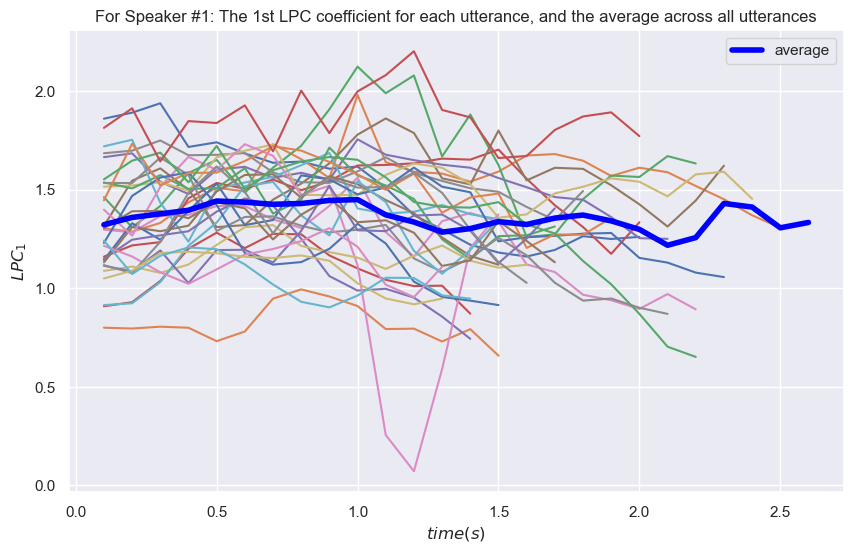

In [29]:
# This is just a graphic depicting the averaging that was just performed
# but for just the 1st speaker and the LPC_1 coefficient.

sns.set(style='darkgrid')

plt.figure(figsize=(10,6))
for name, g in dfs_train[0].groupby('block'):
    plt.plot(g.time/10, g.LPC_1)
plt.plot(dfs_train_mean[0]['LPC_1'].index/10, dfs_train_mean[0]['LPC_1'], 
         color='blue', linewidth=4.0, label='average')
plt.xlabel('$time (s)$')
plt.ylabel('$LPC_1$')
plt.title('For Speaker #1: The 1st LPC coefficient for each utterance, and the average across all utterances')
plt.legend()
plt.show()

### Classification using Dynamic Time Warping and 1-Nearest Neighbor

In [30]:
def get_dtw_distances(train_series, test_series):
    '''
    Calculates the distances between each time-series in the two enumerable lists.
    
    Parameters
    --------
    train_series (list): time-series data (such as the LPC_1 time-series for the 9 speakers) 
    test_series (list):  other time-series data (such as the LPC_1 time-series for each utterance)
    
    Returns
    --------
    dists (array): numpy array of dimension len(train_series) x len(test_series)
        with each element being the DTW distance between each time-series in train_series and test_series.
    '''
    dists = np.empty((len(train_series),len(test_series)))
    for idx1,i in enumerate(test_series):
        for idx2,j in enumerate(train_series):
            dist,_ = fastdtw.fastdtw(i,j,radius=1)
            dists[idx2,idx1] = dist 
    return dists

#### Using only the first LPC coefficient (to start simple and get things working):

In [31]:
# Compile training data for only LPC_1
lpc1_train = []
for df in dfs_train_mean:
    lpc1_train.append(df.loc[:,'LPC_1'].values)

# Compile testing data for only LPC_1
lpc1_test = []
for df in dfs_test:
    blks = df.block.unique()
    for b in blks:
        lpc1_test.append(df[df.block == b].LPC_1.values) # compile all LPC_1 testing data
        
# Sanity check
print("Count of LPC_1 series (training):", len(lpc1_train))
print("Count of LPC_1 series (testing):", len(lpc1_test))
print("Number of utterances (testing):", sum(blocks_per_speaker_test))

Count of LPC_1 series (training): 9
Count of LPC_1 series (testing): 370
Number of utterances (testing): 370


In [32]:
# Create list of actual (not predicted) testing set labels
# Recall that blocks_per_speaker_test = [31,35,88,44,29,24,40,50,29]
test_labels = []
for i in range(9):
    test_labels = test_labels + [i+1]*blocks_per_speaker_test[i]
len(test_labels)

370

In [33]:
# Calculate DTW distances
dists = get_dtw_distances(lpc1_train, lpc1_test)
print(dists.shape)

(9, 370)


In [34]:
# Show classification report
pred_lpc1 = np.argmin(dists, axis=0)+1
print(classification_report(test_labels, pred_lpc1))

              precision    recall  f1-score   support

           1       0.29      0.19      0.23        31
           2       0.38      0.51      0.44        35
           3       0.58      0.34      0.43        88
           4       0.34      0.45      0.39        44
           5       0.31      0.66      0.42        29
           6       0.20      0.12      0.15        24
           7       0.38      0.20      0.26        40
           8       0.39      0.46      0.42        50
           9       0.23      0.28      0.25        29

    accuracy                           0.36       370
   macro avg       0.34      0.36      0.33       370
weighted avg       0.39      0.36      0.36       370



As we can see from the classification report, using just the $LPC_1$ coefficient does not result in a good $F_1$ score (the harmonic mean between recall and precision), as it is only about 37% on average. The baseline accuracy would involve random guessing, which would lead to an accuracy of 1/9 or 11%. So 37% is clearly better than baseline, but let's do better.

#### Now we will use all 12 LPC coefficients, calculate the DTW distance for each, and sum all the distances:

In [35]:
%%time

all_distances = [] # to hold all 12 (one for each coefficient) of the 9x370 distance arrays
for lpc in range(12):
    train_one_LPC = []
    test_one_LPC = []
    for df1 in dfs_train_mean:
        train_one_LPC.append(df1.iloc[:,lpc].values)
    for df2 in dfs_test:
        blks = df2.block.unique()
        for b in blks:
            test_one_LPC.append(df2[df2.block == b].iloc[:,lpc].values)
    all_distances.append(get_dtw_distances(train_one_LPC, test_one_LPC))

CPU times: user 14.3 s, sys: 6.18 ms, total: 14.3 s
Wall time: 14.3 s


In [36]:
# Add all 12 of the 9x370 distance arrays, element-wise
dist_sum = np.zeros(all_distances[0].shape)
for d in all_distances:
    dist_sum = np.add(dist_sum, d)

# Find row index (ie, the speaker) that corresponds to the min distance value
pred_labels = np.argmin(dist_sum, axis=0)+1
print("The predicted speakers are: \n", pred_labels)

# And show the classification report
print('-'*100)
print(classification_report(test_labels, pred_labels))
print('-'*100)
print("Confusion Matrix:")
print(pd.crosstab(pred_labels, np.array(test_labels), rownames=['Pred'], colnames=['Actual']))

print('-'*100)
print("Accuracy (which is also recall in this case) is %.4f" %  accuracy_score(np.array(test_labels), pred_labels))

The predicted speakers are: 
 [1 8 9 1 1 1 1 1 1 1 1 9 9 1 1 9 1 1 1 1 1 9 1 1 9 1 1 1 9 1 9 9 2 2 2 2 9
 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 8 3 3 3 3 3 3 3 3 7 3 3 3 9 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 2 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 9 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 8 5 3 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 5 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 5 9 9 9]
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           1       1.00      0.71      0.83        31
         

As we can see, using all 12 LPC coefficients results in a much better $F_1$ score, namely about 94% on average. 

As mentioned in the paper by Kudo, Toyama, and Shimbo, they achieved a 94.1% recognition rate. The recognition rate (or accuracy or recall) of this classification method is equivalent.